In [ ]:
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install matplotlib

Isolation Forest Accuracy: 0.7459


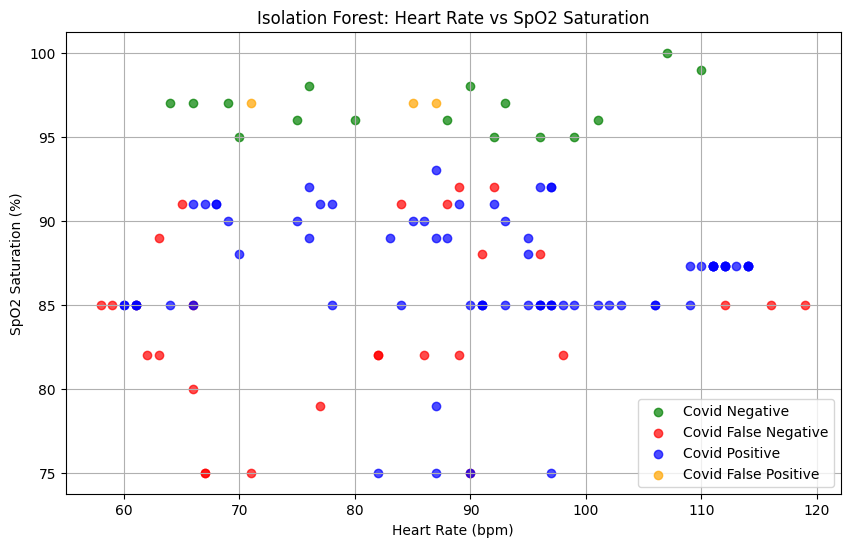

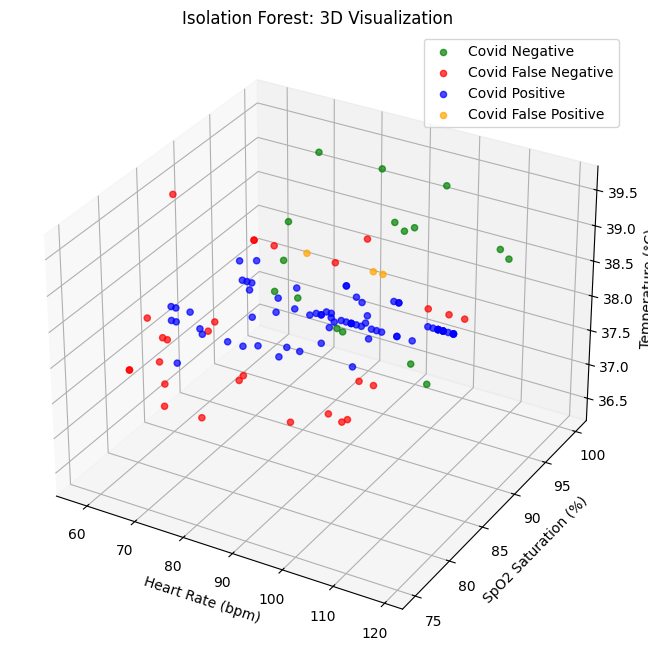

Random Forest Accuracy: 1.0000


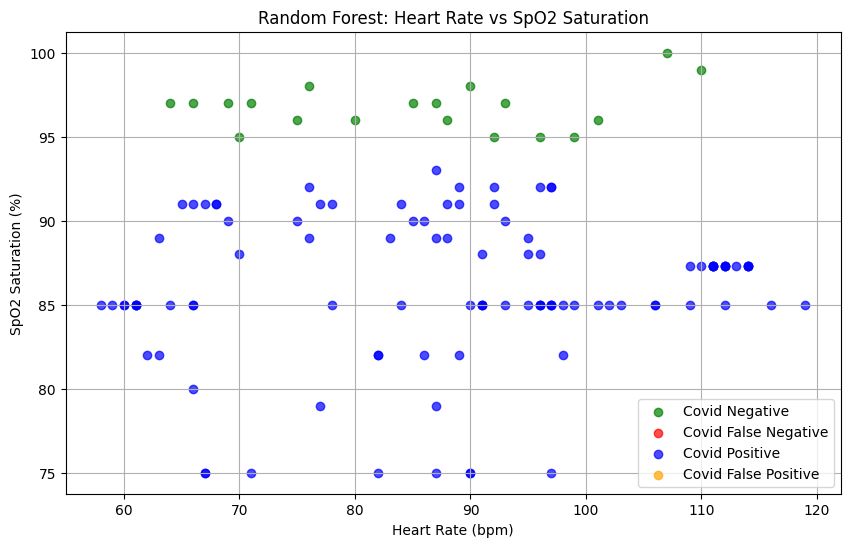

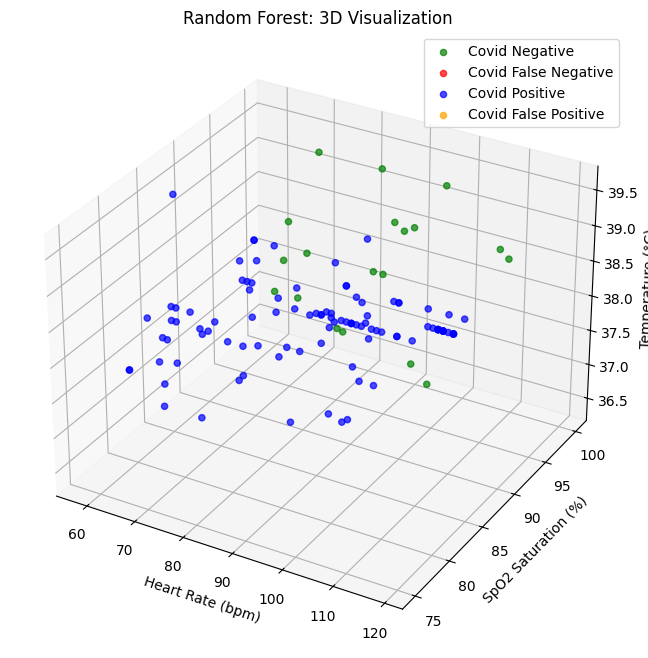

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load data
df = pd.read_csv(r"C:\Users\adria\Downloads\covid-19-26.csv")

def classify_point(prediction, true_label):
    if prediction == -1 and true_label == 0:
        return 'Covid False Negative'
    elif prediction == 1 and true_label == 1:
        return 'Covid False Positive'
    elif prediction == -1 and true_label == 1:
        return 'Covid Negative'
    elif prediction == 1 and true_label == 0:
        return 'Covid Positive'
        

df = df[(df['SpO2_saturation'] > 70) & 
        (df['SpO2_saturation'] <= 100) & 
        (df['temperature'] >= 35) & 
        (df['temperature'] <= 42)]

# Label encoding for health status
label_encoder = LabelEncoder()
df['Health_status_encoded'] = label_encoder.fit_transform(df['Health_status'])

# Features and target
X = df[['heart_rate', 'SpO2_saturation', 'temperature']]
y = df['Health_status_encoded']

# Train-test split (80/20), same for both models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Part 1: Isolation Forest ###
# Train Isolation Forest on the training data
isolation_clf = IsolationForest(contamination='auto', random_state=1)
isolation_clf.fit(X_train, y_train)

#df.loc[X_test] = len(df)

# Predict anomalies (-1 for anomaly, 1 for normal)
#df['anomaly'] = isolation_clf.predict(X_test)
df_result = X_test.copy() 
df_result['anomaly'] = isolation_clf.predict(X_test)
df_result['Health_status'] = y_test.copy()
#print(len(X_test))

# Map predictions (-1 anomaly as infected, 1 normal as non-infected)
#df['isolation_predictions'] = (df['anomaly'] == -1).astype(int)
df_result['isolation_predictions'] = (df_result['anomaly'] == -1).astype(int)

# Classify points based on Isolation Forest predictions
df_result['classification_isolation'] = df_result.apply(
    lambda row: classify_point(row['anomaly'], row['Health_status']), axis=1
)

isolation_accuracy = accuracy_score(y_test, df_result['isolation_predictions'])
print(f"Isolation Forest Accuracy: {isolation_accuracy:.4f}")

# 2D Visualization: Isolation Forest
plt.figure(figsize=(10, 6))
for label, color in {'Covid Negative': 'green', 'Covid False Negative': 'red', 
                     'Covid Positive': 'blue', 'Covid False Positive': 'orange'}.items():
    #subset = df[df['classification_isolation'] == label]
    subset = df_result[df_result['classification_isolation'] == label]
    plt.scatter(subset['heart_rate'], subset['SpO2_saturation'], label=label, color=color, alpha=0.7)
plt.title('Isolation Forest: Heart Rate vs SpO2 Saturation')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('SpO2 Saturation (%)')
plt.legend()
plt.grid(True)
plt.show()

# 3D Visualization: Isolation Forest
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
for label, color in {'Covid Negative': 'green', 'Covid False Negative': 'red', 
                     'Covid Positive': 'blue', 'Covid False Positive': 'orange'}.items():
    #subset = df[df['classification_isolation'] == label]
    subset = df_result[df_result['classification_isolation'] == label]
    ax.scatter(subset['heart_rate'], subset['SpO2_saturation'], subset['temperature'], 
               label=label, color=color, alpha=0.7)
ax.set_title('Isolation Forest: 3D Visualization')
ax.set_xlabel('Heart Rate (bpm)')
ax.set_ylabel('SpO2 Saturation (%)')
ax.set_zlabel('Temperature (°C)')
ax.legend()
plt.show()

### Part 2: Random Forest ###
# Train Random Forest on the same training data
rf_clf = RandomForestClassifier(n_estimators=100, random_state=1)
rf_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_clf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Confusion matrix and classifications
df['classification_rf'] = 'Undefined'
df.loc[y_test.index, 'classification_rf'] = [
    'Covid Negative' if yt == 1 and yp == 1 else
    'Covid False Negative' if yt == 0 and yp == 1 else
    'Covid Positive' if yt == 0 and yp == 0 else
    'Covid False Positive'
    for yt, yp in zip(y_test, y_pred)
]

# 2D Visualization: Random Forest
plt.figure(figsize=(10, 6))
for label, color in {'Covid Negative': 'green', 'Covid False Negative': 'red', 
                     'Covid Positive': 'blue', 'Covid False Positive': 'orange'}.items():
    subset = df[df['classification_rf'] == label]
    plt.scatter(subset['heart_rate'], subset['SpO2_saturation'], label=label, color=color, alpha=0.7)
plt.title('Random Forest: Heart Rate vs SpO2 Saturation')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('SpO2 Saturation (%)')
plt.legend()
plt.grid(True)
plt.show()

# 3D Visualization: Random Forest
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
for label, color in {'Covid Negative': 'green', 'Covid False Negative': 'red', 
                     'Covid Positive': 'blue', 'Covid False Positive': 'orange'}.items():
    subset = df[df['classification_rf'] == label]
    ax.scatter(subset['heart_rate'], subset['SpO2_saturation'], subset['temperature'], 
               label=label, color=color, alpha=0.7)
ax.set_title('Random Forest: 3D Visualization')
ax.set_xlabel('Heart Rate (bpm)')
ax.set_ylabel('SpO2 Saturation (%)')
ax.set_zlabel('Temperature (°C)')
ax.legend()
plt.show()
